<a href="https://colab.research.google.com/github/peluca13/LDM_Cuadernos/blob/main/ResNet50.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
%tensorflow_version 2.7.0

Colab only includes TensorFlow 2.x; %tensorflow_version has no effect.


In [ ]:
!sudo pip3 install keras
!sudo pip install tensorflow==2.7.0.

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 489.6 MB 24 kB/s 
     |████████████████████████████████| 463 kB 76.3 MB/s 
     |████████████████████████████████| 1.3 MB 61.8 MB/s 
  Attempting uninstall: tensorflow-estimator
    Found existing installation: tensorflow-estimator 2.8.0
    Uninstalling tensorflow-estimator-2.8.0:
      Successfully uninstalled tensorflow-estimator-2.8.0
  Attempting uninstall: keras
    Found existing installation: keras 2.8.0
    Uninstalling keras-2.8.0:
      Successfully uninstalled keras-2.8.0
  Attempting uninstall: gast
    Found existing installation: gast 0.5.3
    Uninstalling gast-0.5.3:
      Successfully uninstalled gast-0.5.3
  Attempting uninstall: tensorflow
    Found existing installation: tensorflow 2.8.2+zzzcolab20220719082949
    Uninstalling ten

In [ ]:
import tensorflow as tf 
import numpy as np
import os
import pandas as pd
from tensorflow.keras import layers
from tensorflow.keras.layers.experimental import preprocessing
from tensorflow.keras.preprocessing import image_dataset_from_directory
from tensorflow.keras.callbacks import TensorBoard      #Observar funcionamiento del modelo
from tensorflow.keras.preprocessing.image import ImageDataGenerator   #Generar imagenes extra
from mlxtend.plotting import plot_confusion_matrix #ver la matriz en la interfaz grafica
from keras.models import load_model #para cargar el modelo grabado
from sklearn.metrics import confusion_matrix, f1_score, roc_curve, precision_score, recall_score, accuracy_score, roc_auc_score
from sklearn import metrics #permite calcular las metricas con un copilado y no por separado
from mlxtend.plotting import plot_confusion_matrix #ver la matriz en la interfaz grafica
import matplotlib.pyplot as plt
import pathlib
from sklearn.ensemble import RandomForestClassifier
from sklearn import datasets
from sklearn.model_selection import learning_curve

In [ ]:
BATCH_SIZE = 32
IMG_SIZE = (256, 256)

In [ ]:
PATH='/content/drive/MyDrive/8vo SEMESTRE/DataSet'
train_dir = os.path.join(PATH, 'train')
test_dir = os.path.join(PATH, 'test')

In [ ]:
train_dataset = image_dataset_from_directory(train_dir,
                                             shuffle=True,
                                             validation_split=0.2,
                                             subset="training",
                                             seed=42,
                                             batch_size=BATCH_SIZE,
                                             image_size=IMG_SIZE)

Found 236 files belonging to 2 classes.
Using 189 files for training.


In [ ]:
class_names = train_dataset.class_names

In [ ]:
class_names

['noPitanga', 'pitanga']

In [ ]:
validation_dataset = image_dataset_from_directory(train_dir,
                                             shuffle=True,
                                             validation_split=0.2,
                                             subset="validation",
                                             seed=42,
                                             batch_size=BATCH_SIZE,
                                             image_size=IMG_SIZE)

Found 236 files belonging to 2 classes.
Using 47 files for validation.


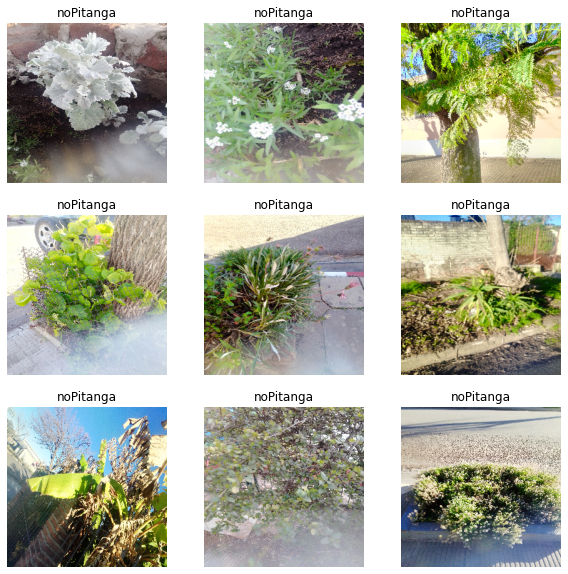

In [ ]:
plt.figure(figsize=(10, 10))
for images, labels in train_dataset.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(class_names[labels[i]])
        plt.axis("off")

In [ ]:
test_dataset = image_dataset_from_directory(test_dir,
                                             batch_size=BATCH_SIZE,
                                             image_size=IMG_SIZE,
                                             )

Found 101 files belonging to 2 classes.


In [ ]:
AUTOTUNE = tf.data.AUTOTUNE
train_dataset = train_dataset.prefetch(buffer_size=AUTOTUNE)
validation_dataset = validation_dataset.prefetch(buffer_size=AUTOTUNE)
test_dataset = test_dataset.prefetch(buffer_size=AUTOTUNE)

In [ ]:
data_augmentation = tf.keras.Sequential(
    [
        preprocessing.RandomFlip("horizontal"),
        preprocessing.RandomRotation(0.2),
        preprocessing.RandomZoom(0.3)
    ]
)

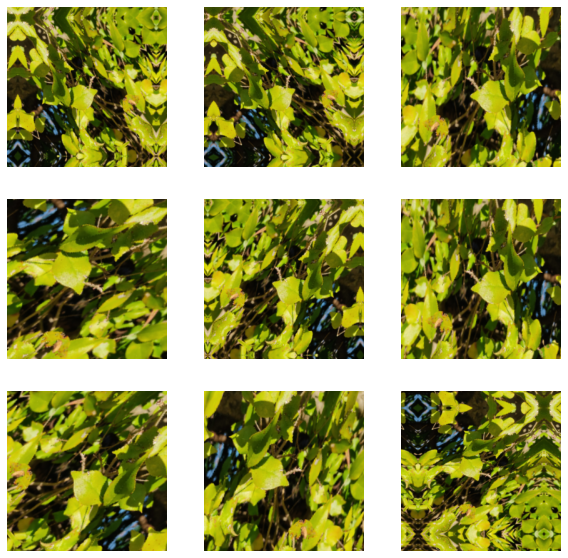

In [ ]:
for image, _ in train_dataset.take(1):
    plt.figure(figsize=(10, 10))
    first_image = image[0]
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        augmented_image = data_augmentation(tf.expand_dims(first_image, 0))
        plt.imshow(augmented_image[0] / 255)
        plt.axis('off')

In [ ]:
rescale = preprocessing.Rescaling(1./255)

# Generacion del modelo

Transfer learning con modelo convolucional pre entrenado RestNet50


In [ ]:
base_model_resnet50 =''
base_model_resnet50 = tf.keras.applications.resnet50.ResNet50(weights = 'imagenet', include_top = False, input_shape = (256,256,3))

In [ ]:
base_model_resnet50.trainable = False

In [ ]:
inputs = tf.keras.Input(shape=(256, 256, 3), name='image')
x = data_augmentation(inputs)
x = tf.keras.applications.resnet50.preprocess_input(x)
x = base_model_resnet50(x)
x = layers.GlobalAveragePooling2D()(x)
x = layers.Flatten()(x)
x = layers.Dense(1000, activation='relu')(x)
x = layers.Dropout(.3)(x)
outputs = layers.Dense(1)(x)
model_resnet50 = tf.keras.Model(inputs, outputs, name='resnet50')

In [ ]:
model_resnet50.summary()

Model: "resnet50"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 image (InputLayer)          [(None, 256, 256, 3)]     0         
                                                                 
 sequential (Sequential)     (None, 256, 256, 3)       0         
                                                                 
 tf.__operators__.getitem_1   (None, 256, 256, 3)      0         
 (SlicingOpLambda)                                               
                                                                 
 tf.nn.bias_add_1 (TFOpLambd  (None, 256, 256, 3)      0         
 a)                                                              
                                                                 
 resnet50 (Functional)       (None, 8, 8, 2048)        23587712  
                                                                 
 global_average_pooling2d_1   (None, 2048)             0  

In [ ]:
model_resnet50.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=.0005),
              loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [ ]:
callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=2, restore_best_weights=True)



In [ ]:
def plotLearningCurve(history):
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']

    loss = history.history['loss']
    val_loss = history.history['val_loss']

    plt.figure(figsize=(8, 8))
    plt.subplot(2, 1, 1)
    plt.plot(acc, label='Training Accuracy')
    plt.plot(val_acc, label='Validation Accuracy')
    plt.legend(loc='lower right')
    plt.ylabel('Accuracy')
    plt.ylim([min(plt.ylim()),1])
    plt.title('Training and Validation Accuracy')

    plt.subplot(2, 1, 2)
    plt.plot(loss, label='Training Loss')
    plt.plot(val_loss, label='Validation Loss')
    plt.legend(loc='upper right')
    plt.ylabel('Cross Entropy')
    plt.ylim([0,1.0])
    plt.title('Training and Validation Loss')
    plt.xlabel('epoch')
    plt.show()

In [ ]:
history_resnet50 = model_resnet50.fit(train_dataset,
                        epochs=10,
                        validation_data=validation_dataset,
                        callbacks=[callback])

NameError: ignored

In [ ]:
plotLearningCurve(history_resnet50)

NameError: ignored

In [ ]:
#Guardamos el modelo 
model_resnet50.save('/content/drive/MyDrive/8vo SEMESTRE/DataSet/Modelos/ResNet50.h5'),
model_resnet50.save_weights('/content/drive/MyDrive/8vo SEMESTRE/DataSet/Modelos/ResNet50/pesos')

In [ ]:
model_resnet50.evaluate(test_dataset)

4/4 [==============================] - 34s 5s/step - loss: 0.2676 - accuracy: 0.9010


[0.26763537526130676, 0.9009901285171509]

In [ ]:
%load_ext tensorboard
%tensorboard --logdir '/content/drive/MyDrive/8vo SEMESTRE/DataSet/Modelos/ResNet50/Board'

In [ ]:
from sklearn.metrics import confusion_matrix, f1_score, roc_curve, precision_score, recall_score, accuracy_score, roc_auc_score
from sklearn import metrics #permite calcular las metricas con un copilado y no por separado
from mlxtend.plotting import plot_confusion_matrix #ver la matriz en la interfaz grafica
from keras.models import load_model #para cargar el modelo grabado
from keras.preprocessing.image import ImageDataGenerator 
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline


In [ ]:
#tienen que ser las mismas que se asiganron para el entrenamiento
width_shape = 224
height_shape = 224
batch_size = 32 

names = ['pitanga','NoPitanga']

In [ ]:

test_datagen = ImageDataGenerator()

test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=(width_shape, height_shape), 
    batch_size = batch_size,
    class_mode='categorical', 
    shuffle=False)

custom_Model= load_model('/content/drive/MyDrive/8vo SEMESTRE/DataSet/Modelos/ResNet50')

predictions = custom_Model.predict_generator(generator=test_generator)

y_pred = np.argmax(predictions, axis=1)

y_real = test_generator.classes


matc=confusion_matrix(y_real, y_pred)

plot_confusion_matrix(conf_mat=matc,
                                colorbar=True,
                                show_normed=False)
plt.tight_layout()

print(metrics.classification_report(y_real,y_pred, digits = 4))

Found 101 images belonging to 2 classes.


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  del sys.path[0]
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Unknown node type <gast.gast.Expr object at 0x7ff7515651d0>
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Unknown node type <gast.gast.Expr object at 0x7ff7515651d0>
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
